In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

np.random.seed(0)
torch.manual_seed(0)

In [2]:
#%% Data Loading and Preprocessing

hts_df = pd.read_csv('hts_example.csv', index_col=None)

# One-hot encode the selected data
encoder = OneHotEncoder(sparse=False)
one_hot_data = encoder.fit_transform(hts_df.values)

# Convert the data to torch tensors
data_tensor = torch.tensor(one_hot_data, dtype=torch.float32)
dataset = TensorDataset(data_tensor)

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create DataLoader with batch size 256
data_loader = DataLoader(dataset, batch_size=256, shuffle=True)

Using device: cuda:0


In [3]:
# Diffusion hyperparameters
T = 1000  # Number of diffusion steps
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0]).to(device), alphas_cumprod[:-1]])

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).to(device)

input_dim = one_hot_data.shape[1]
hidden_dim = 256

# Time embedding function
def get_timestep_embedding(timesteps, embedding_dim):
    half_dim = embedding_dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb).float()
    emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb

# Define the neural network model
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, time_embedding_dim=128):
        super(DiffusionModel, self).__init__()
        self.time_embedding_dim = time_embedding_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim + time_embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        t_emb = get_timestep_embedding(t, self.time_embedding_dim)
        x_t = torch.cat([x, t_emb], dim=1)
        return self.net(x_t)

# Initialize the model and optimizer
model = DiffusionModel(input_dim=input_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-3)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)
num_epochs = 7


In [4]:
# Training the Diffusion Model

for epoch in range(num_epochs):
    for batch in data_loader:
        x_0 = batch[0].to(device)
        batch_size = x_0.size(0)
        t = torch.randint(0, T, (batch_size,), device=device).long()

        # Calculate diffusion coefficients
        sqrt_alpha_cumprod_t = sqrt_alphas_cumprod[t].unsqueeze(1)
        sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod[t].unsqueeze(1)

        # Forward diffusion (adding noise)
        noise = torch.randn_like(x_0)
        x_t = sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise

        # Predict the noise
        noise_pred = model(x_t, t)

        # Compute the loss (MSE between the true and predicted noise)
        loss = nn.MSELoss()(noise_pred, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/7, Loss: 0.0574
Epoch 2/7, Loss: 0.0678
Epoch 3/7, Loss: 0.0502
Epoch 4/7, Loss: 0.0824
Epoch 5/7, Loss: 0.0592
Epoch 6/7, Loss: 0.0488
Epoch 7/7, Loss: 0.0644


In [17]:
torch.save(model.state_dict(), 'models/diffusion_discrete.pth')

In [5]:
#%% Generating New Data

model.eval()
num_samples_gen = 3000
x_t = torch.randn(num_samples_gen, input_dim).to(device)

for t in reversed(range(T)):
    t_tensor = torch.full((num_samples_gen,), t, dtype=torch.long, device=device)
    beta_t = betas[t]
    sqrt_alpha_t = torch.sqrt(alphas[t])
    sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod[t]

    noise_pred = model(x_t, t_tensor)

    coef1 = 1 / sqrt_alpha_t
    coef2 = beta_t / sqrt_one_minus_alpha_cumprod_t
    mu = coef1 * (x_t - coef2 * noise_pred)

    if t > 0:
        z = torch.randn_like(x_t).to(device)
        x_t = mu + torch.sqrt(beta_t) * z
    else:
        x_t = mu

In [6]:
# Move data to CPU and convert to numpy
x_t_np = x_t.detach().cpu().numpy()

# Get the number of categories per feature
n_categories = [len(cat) for cat in encoder.categories_]
indices = np.cumsum([0] + n_categories)

# Map the one-hot encoded vectors back to original categories
generated_data = []
for sample in x_t_np:
    sample_categories = []
    for i in range(len(n_categories)):
        start_idx = indices[i]
        end_idx = indices[i + 1]
        category_logits = sample[start_idx:end_idx]
        category_idx = np.argmax(category_logits)
        category_value = encoder.categories_[i][category_idx]
        sample_categories.append(category_value)
    generated_data.append(sample_categories)

generated_data = np.array(generated_data)


Generated data:
[[0. 1. 6. 4.]
 [1. 1. 3. 0.]
 [4. 1. 4. 0.]
 ...
 [0. 1. 3. 4.]
 [4. 1. 3. 0.]
 [0. 0. 0. 0.]]


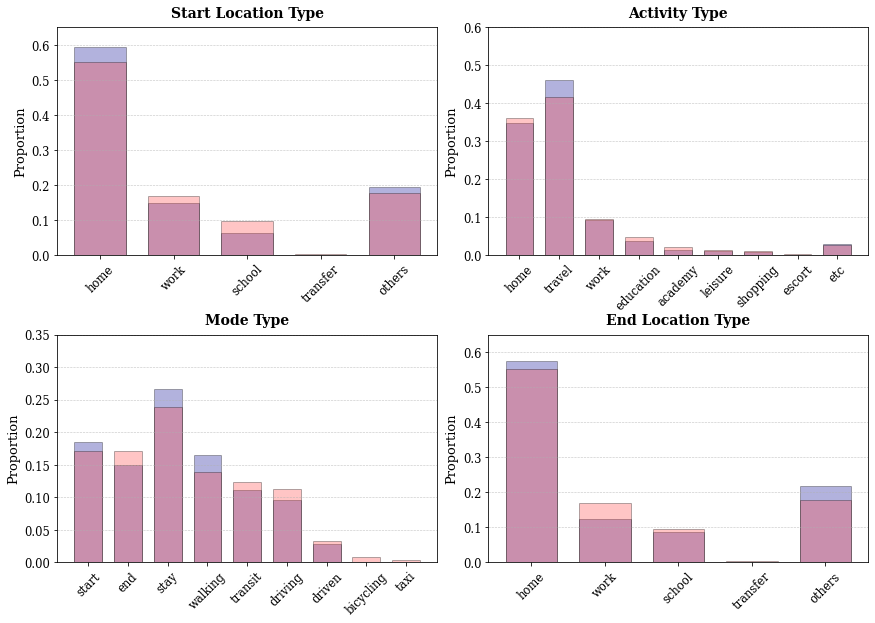

In [16]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(h_pad=6, w_pad=2)

ticks_list = [5, 9, 9, 5]
attribute_list = ['start_type', 'act_num', 'mode_num', 'end_type']
title_list = ['Start Location Type', 'Activity Type', 'Mode Type', 'End Location Type']
location_list = ['home', 'work', 'school', 'transfer', 'others']
act_list = ['home', 'travel', 'work', 'education', 'academy', 'leisure', 'shopping', 'escort', 'etc']
mode_list = ['start', 'end', 'stay', 'walking', 'transit', 'driving', 'driven', 'bicycling', 'taxi']
axis_list = [location_list, act_list, mode_list, location_list]
ylim_list = [0.65, 0.6, 0.35, 0.65]

start = 0

for K, name, title, axis, ylim, ax in zip(ticks_list, attribute_list, title_list, axis_list, ylim_list, axs.flatten()):

    unique, counts = np.unique(generated_data[:, start], return_counts=True)
    ax.set_ylim([0, ylim])
    ax.bar(unique, counts/counts.sum(), color='#00008F', edgecolor='black', width=0.7, alpha=0.3)
    
    unique, counts = np.unique(hts_df[name].values, return_counts=True)
    ax.set_ylim([0, ylim])
    ax.bar(unique, counts/counts.sum(), color='#FF4040', edgecolor='black', width=0.7, alpha=0.3)
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.set_xticks(np.arange(K))
    ax.tick_params(axis='both', which='major', labelsize=11.5)
    ax.set_xticklabels(axis, rotation=45)
    ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7)
    ax.set_ylabel('Proportion', fontsize=13)
    end = start + 1
    start = end

plt.savefig(f'diff_discrete.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()